<a href="https://colab.research.google.com/github/kkrphm/project-Models/blob/main/Resnet_Model50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import os #file I/O
import cv2
import itertools
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt #used for plotting and analyzing data
import sklearn as sk
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,roc_auc_score,roc_curve, auc
import plotly.graph_objs as go
from plotly import tools
# tensorflow
#!pip install -U tensorflow==2.8
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,LayerNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model,load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array,ImageDataGenerator, load_img
import random
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.utils import np_utils
from tensorflow.keras.utils  import to_categorical
from numpy import expand_dims
import warnings
warnings.filterwarnings("ignore")
import matplotlib
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'axes.linewidth':'1',
              'axes.edgecolor':'0',
              'figure.dpi': 600
               }

## **Training & Validation Datasets**

In [ ]:
train_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Training' #data is already in colab file
validation_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
test_data_dir='/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
nb_train_samples =488
nb_validation_samples =169
nb_test_samples =153
epochs = 60
batch_size = 64
num_classes=4
# input image dimensions
img_rows, img_cols = 224,224

# **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=2,
  horizontal_flip=True,
  vertical_flip=True
  )

val_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=2,
  horizontal_flip=True,
  vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=False)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Data Visualization**

In [ ]:
index = ['glioma','meningioma','notumor','pituitary']
trained_classes=[]
for i in train_generator.classes:
  trained_classes.append(index[i])
print(trained_classes[:5])
test_classes=[]
for i in test_generator.classes:
  test_classes.append(index[i])
print(test_classes[:5])

['glioma', 'glioma', 'glioma', 'glioma', 'glioma']
['glioma', 'glioma', 'glioma', 'glioma', 'glioma']


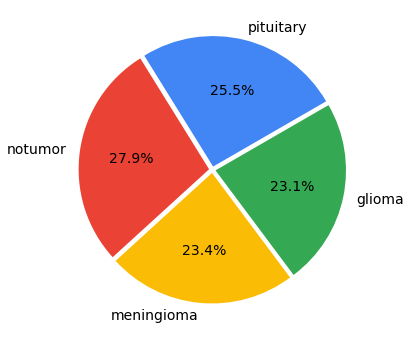

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in trained_classes if x=='pituitary']),
         len([x for x in trained_classes if x=='notumor']),
         len([x for x in trained_classes if x=='meningioma']),
         len([x for x in trained_classes if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

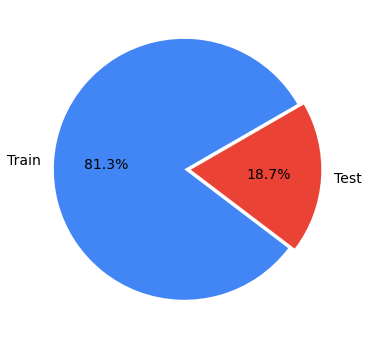

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(trained_classes), len(test_classes)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# **Augmented Images**

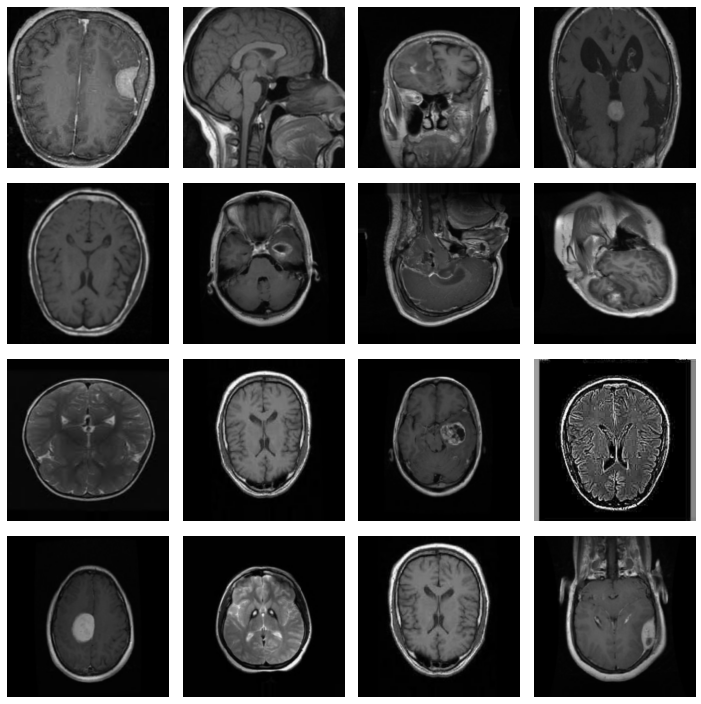

In [ ]:
# next function iterates over the training set and separates the images and their labels 
imgs, labels = next(train_generator)

#we define a function that prints the first 10 images from the training set 
def plotImages(images_arr):
    fig, axes = plt.subplots(4,4, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        img = cv2.resize(img, (512,512))
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
# calling our function to print the first 10 images
plotImages(imgs)


# **Download Pre-trained model(Resnet50)**

In [ ]:
resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
len(resnet_model.layers)

94781440/94765736 [==============================] - 0s 0us/step


175

## **Model Layers Freezing**

In [ ]:
resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Set all layers to non-trainable
for layer in resnet_model.layers[:171]:
    layer.trainable = False

for layer in resnet_model.layers[171:]:
    layer.trainable = True

## **Add more layers**

**To convert 50-class classification model into 4-class classification model**

In [ ]:
model = Sequential()
model.add(Input(shape=(img_rows, img_cols,3)))
model.add(resnet_model)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_2 (Dropout)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 36,380,292


# **Model Compilation**

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

# **Set Checkpoint to save model at 640 epoches**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Project (1)/Resnet/wm_save"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*batch_size,
                                                 verbose=1)

## **Model fitting**

In [ ]:
history=model.fit(train_generator, 
          epochs=20,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/20
90/90 [==============================] - 3764s 42s/step - loss: 1.2142 - accuracy: 0.5347 - auc: 0.7789 - val_loss: 1.2060 - val_accuracy: 0.3944 - val_auc: 0.7382
Epoch 2/20
90/90 [==============================] - 99s 1s/step - loss: 0.8884 - accuracy: 0.6341 - auc: 0.8625 - val_loss: 1.1276 - val_accuracy: 0.5309 - val_auc: 0.7825
Epoch 3/20
90/90 [==============================] - 98s 1s/step - loss: 0.8436 - accuracy: 0.6499 - auc: 0.8765 - val_loss: 0.9702 - val_accuracy: 0.5973 - val_auc: 0.8543
Epoch 4/20
90/90 [==============================] - 97s 1s/step - loss: 0.8043 - accuracy: 0.6677 - auc: 0.8879 - val_loss: 0.8121 - val_accuracy: 0.6789 - val_auc: 0.8964
Epoch 5/20
90/90 [==============================] - 97s 1s/step - loss: 0.8004 - accuracy: 0.6698 - auc: 0.8887 - val_loss: 0.7679 - val_accuracy: 0.6804 - val_auc: 0.8996
Epoch 6/20
90/90 [==============================] - 96s 1s/step - loss: 0.7453 - accuracy: 0.6905 - auc: 0.9043 - val_loss: 0.7590 - val_

## **Model evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

21/21 [==============================] - 7s 307ms/step - loss: 0.7358 - accuracy: 0.7185 - auc: 0.9116
Test loss: 0.7357789874076843
Test accuracy: 0.7185354828834534


# **Progess of Model accuracy & Loss**

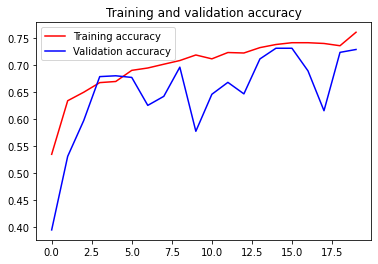

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

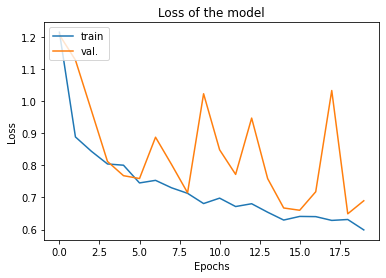

In [ ]:
# comparing training and testing loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Model Save**

In [ ]:
model.save('/content/drive/MyDrive/resnet model/71%model1.h5')

# **Model Retraining**

In [ ]:
history1=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 103s 1s/step - loss: 0.6118 - accuracy: 0.7477 - auc: 0.9349 - val_loss: 0.6504 - val_accuracy: 0.7399 - val_auc: 0.9262
Epoch 2/50
29/90 [========>.....................] - ETA: 55s - loss: 0.5790 - accuracy: 0.7705 - auc: 0.9413
Epoch 2: saving model to /content/drive/MyDrive/Project/Resnet/wm_save
90/90 [==============================] - 100s 1s/step - loss: 0.5962 - accuracy: 0.7624 - auc: 0.9380 - val_loss: 0.7377 - val_accuracy: 0.6941 - val_auc: 0.9050
Epoch 3/50
90/90 [==============================] - 96s 1s/step - loss: 0.5871 - accuracy: 0.7588 - auc: 0.9399 - val_loss: 0.9281 - val_accuracy: 0.6415 - val_auc: 0.8750
Epoch 4/50
90/90 [==============================] - 98s 1s/step - loss: 0.5947 - accuracy: 0.7530 - auc: 0.9383 - val_loss: 0.6269 - val_accuracy: 0.7201 - val_auc: 0.9296
Epoch 5/50
90/90 [==============================] - 96s 1s/step - loss: 0.5872 - accuracy: 0.7644 - auc: 0.9398 - val_loss: 0.6240 - val_accu

# **Retrained Model Evaluation**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

## **Retrained Model Accuracy & Loss Progress**

In [ ]:
%matplotlib inline
acc = history1.history['accuracy']
val_acc =history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# comparing training and testing loss 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Model Reload from intermediate epoch**

Where Model Saved at latest checkpoint

In [ ]:
model.load_weights(checkpoint_path)

## **Reloaded Model Evaluation**

**To verify Model is Latest Model or not ?**

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


21/21 [==============================] - 5s 247ms/step - loss: 0.5621 - accuracy: 0.7925 - auc: 0.9474
Test loss: 0.5621493458747864
Test accuracy: 0.7925248146057129


# **Latest Model Save to Drive**

In [ ]:
model.save('/content/drive/MyDrive/Resnet model/79%model2.h5')

## **Training Continue from where Model Training stopped.**

In [ ]:
history2=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 1236s 14s/step - loss: 0.5068 - accuracy: 0.7934 - auc: 0.9545 - val_loss: 0.5606 - val_accuracy: 0.7834 - val_auc: 0.9449
Epoch 2/50
90/90 [==============================] - 93s 1s/step - loss: 0.5096 - accuracy: 0.7938 - auc: 0.9543 - val_loss: 0.5777 - val_accuracy: 0.7567 - val_auc: 0.9410
Epoch 3/50
90/90 [==============================] - 95s 1s/step - loss: 0.4940 - accuracy: 0.8011 - auc: 0.9568 - val_loss: 0.6194 - val_accuracy: 0.7323 - val_auc: 0.9316
Epoch 4/50
90/90 [==============================] - 95s 1s/step - loss: 0.4850 - accuracy: 0.8058 - auc: 0.9586 - val_loss: 0.5586 - val_accuracy: 0.7773 - val_auc: 0.9462
Epoch 5/50
90/90 [==============================] - 93s 1s/step - loss: 0.4996 - accuracy: 0.7976 - auc: 0.9559 - val_loss: 0.6492 - val_accuracy: 0.7239 - val_auc: 0.9260
Epoch 6/50
90/90 [==============================] - 95s 1s/step - loss: 0.5095 - accuracy: 0.7908 - auc: 0.9541 - val_loss: 0.6852 - val_

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

21/21 [==============================] - 6s 264ms/step - loss: 0.6982 - accuracy: 0.7567 - auc: 0.9333
Test loss: 0.6981751322746277
Test accuracy: 0.7566742897033691


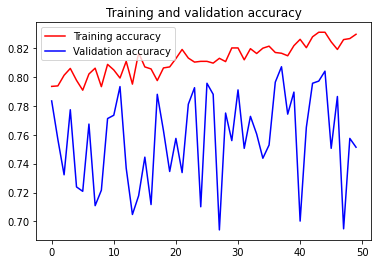

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history2.history['accuracy']
val_acc =history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

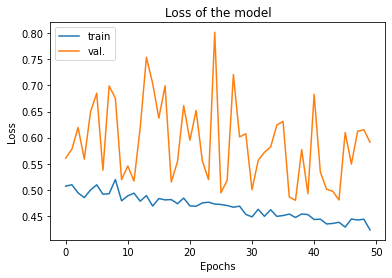

In [ ]:
# comparing training and testing loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Continue Model Training and Evaluation for more epoches.**

In [ ]:
history3=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 100s 1s/step - loss: 0.4351 - accuracy: 0.8204 - auc: 0.9659 - val_loss: 0.6906 - val_accuracy: 0.7201 - val_auc: 0.9245
Epoch 2/50
90/90 [==============================] - 97s 1s/step - loss: 0.4185 - accuracy: 0.8297 - auc: 0.9686 - val_loss: 0.5749 - val_accuracy: 0.7620 - val_auc: 0.9429
Epoch 3/50
90/90 [==============================] - 95s 1s/step - loss: 0.4344 - accuracy: 0.8279 - auc: 0.9663 - val_loss: 0.6021 - val_accuracy: 0.7666 - val_auc: 0.9416
Epoch 4/50
90/90 [==============================] - 96s 1s/step - loss: 0.4474 - accuracy: 0.8221 - auc: 0.9644 - val_loss: 0.4646 - val_accuracy: 0.8108 - val_auc: 0.9618
Epoch 5/50
90/90 [==============================] - 94s 1s/step - loss: 0.4330 - accuracy: 0.8267 - auc: 0.9665 - val_loss: 0.5667 - val_accuracy: 0.7719 - val_auc: 0.9471
Epoch 6/50
90/90 [==============================] - 96s 1s/step - loss: 0.4268 - accuracy: 0.8262 - auc: 0.9674 - val_loss: 0.4853 - val_ac

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

21/21 [==============================] - 6s 255ms/step - loss: 0.4130 - accuracy: 0.8291 - auc: 0.9710
Test loss: 0.4130423963069916
Test accuracy: 0.8291380405426025


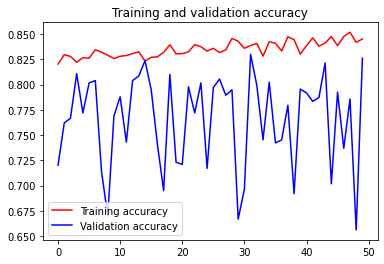

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history3.history['accuracy']
val_acc =history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

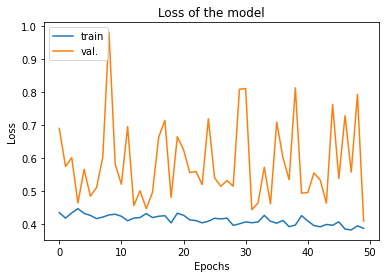

In [ ]:
# comparing training and testing loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
history4=model.fit(train_generator, 
          epochs=50,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/50
90/90 [==============================] - 102s 1s/step - loss: 0.3861 - accuracy: 0.8463 - auc: 0.9731 - val_loss: 0.4493 - val_accuracy: 0.8108 - val_auc: 0.9635
Epoch 2/50
90/90 [==============================] - 93s 1s/step - loss: 0.3857 - accuracy: 0.8445 - auc: 0.9730 - val_loss: 0.4202 - val_accuracy: 0.8299 - val_auc: 0.9685
Epoch 3/50
90/90 [==============================] - 94s 1s/step - loss: 0.3935 - accuracy: 0.8452 - auc: 0.9720 - val_loss: 0.5367 - val_accuracy: 0.7902 - val_auc: 0.9528
Epoch 4/50
90/90 [==============================] - 92s 1s/step - loss: 0.3972 - accuracy: 0.8396 - auc: 0.9713 - val_loss: 0.5941 - val_accuracy: 0.7262 - val_auc: 0.9401
Epoch 5/50
90/90 [==============================] - 93s 1s/step - loss: 0.3841 - accuracy: 0.8459 - auc: 0.9731 - val_loss: 0.4747 - val_accuracy: 0.8009 - val_auc: 0.9625
Epoch 6/50
90/90 [==============================] - 93s 1s/step - loss: 0.3974 - accuracy: 0.8468 - auc: 0.9714 - val_loss: 0.5119 - val_ac

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

21/21 [==============================] - 5s 251ms/step - loss: 0.4662 - accuracy: 0.8253 - auc: 0.9660
Test loss: 0.46618926525115967
Test accuracy: 0.8253241777420044


**Model Accuracy is less than previous Accuracy.**

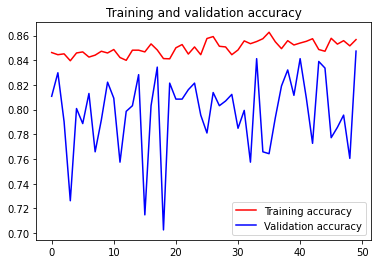

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history4.history['accuracy']
val_acc =history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

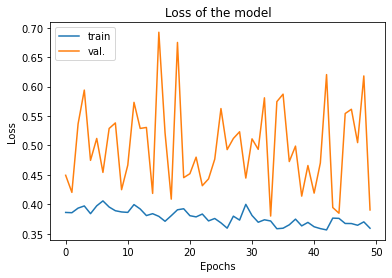

In [ ]:
# comparing training and testing loss 
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

In [ ]:
history5=model.fit(train_generator, 
          epochs=25,
          validation_data=validation_generator,
          verbose=1,
          callbacks=[cp_callback])  # Pass callback to training

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.)

Epoch 1/25
90/90 [==============================] - 99s 1s/step - loss: 0.3549 - accuracy: 0.8580 - auc: 0.9770 - val_loss: 0.5787 - val_accuracy: 0.7811 - val_auc: 0.9485
Epoch 2/25
90/90 [==============================] - 94s 1s/step - loss: 0.3577 - accuracy: 0.8577 - auc: 0.9767 - val_loss: 0.5152 - val_accuracy: 0.7986 - val_auc: 0.9562
Epoch 3/25
90/90 [==============================] - 94s 1s/step - loss: 0.3699 - accuracy: 0.8554 - auc: 0.9752 - val_loss: 0.6195 - val_accuracy: 0.7521 - val_auc: 0.9383
Epoch 4/25
90/90 [==============================] - 92s 1s/step - loss: 0.3768 - accuracy: 0.8542 - auc: 0.9744 - val_loss: 0.4237 - val_accuracy: 0.8200 - val_auc: 0.9675
Epoch 5/25
90/90 [==============================] - 93s 1s/step - loss: 0.3462 - accuracy: 0.8655 - auc: 0.9780 - val_loss: 0.5829 - val_accuracy: 0.7681 - val_auc: 0.9467
Epoch 6/25
90/90 [==============================] - 92s 1s/step - loss: 0.3596 - accuracy: 0.8578 - auc: 0.9765 - val_loss: 0.5803 - val_acc

In [ ]:
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
a1=round(score[1]*100,2)
#Saving the weight of the model
model.save('/content/drive/MyDrive/Resnet model/'+str(a1)+'bt1.h5')

21/21 [==============================] - 5s 250ms/step - loss: 0.5214 - accuracy: 0.8253 - auc: 0.9595
Test loss: 0.521397054195404
Test accuracy: 0.8253241777420044


**Model accuacy simillar to previous accuracy.**

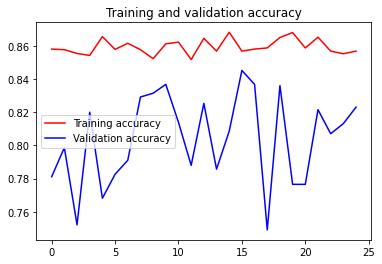

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history5.history['accuracy']
val_acc =history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

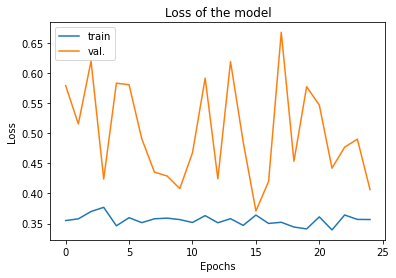

In [ ]:
# comparing training and testing loss 
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

## **Load the High Accuracy Model for Testing.**

In [ ]:
model_nw=load_model('/content/drive/MyDrive/Resnet model/82.91bt1.h5')

# **Model Evaluation**

# **Accuracy**

In [ ]:
score = model_nw.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 744s 37s/step - loss: 0.4130 - accuracy: 0.8291 - auc: 0.9710
Test loss: 0.4130423963069916
Test accuracy: 0.8291380405426025


# **Confusion matrix**

In [ ]:
pred_test = model_nw.predict(test_generator, verbose=1)

21/21 [==============================] - 339s 16s/step


In [ ]:
classes=list(train_generator.class_indices.keys())


predict_labels_Test
Numbre of glioma : 294
Numbre of meningioma : 226
Numbre of notumor : 428
Numbre of pituitary : 363

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       294
           1       0.58      0.78      0.66       226
           2       0.97      0.92      0.95       428
           3       0.97      0.80      0.88       363

   micro avg       0.83      0.83      0.83      1311
   macro avg       0.82      0.82      0.81      1311
weighted avg       0.85      0.83      0.84      1311
 samples avg       0.83      0.83      0.83      1311



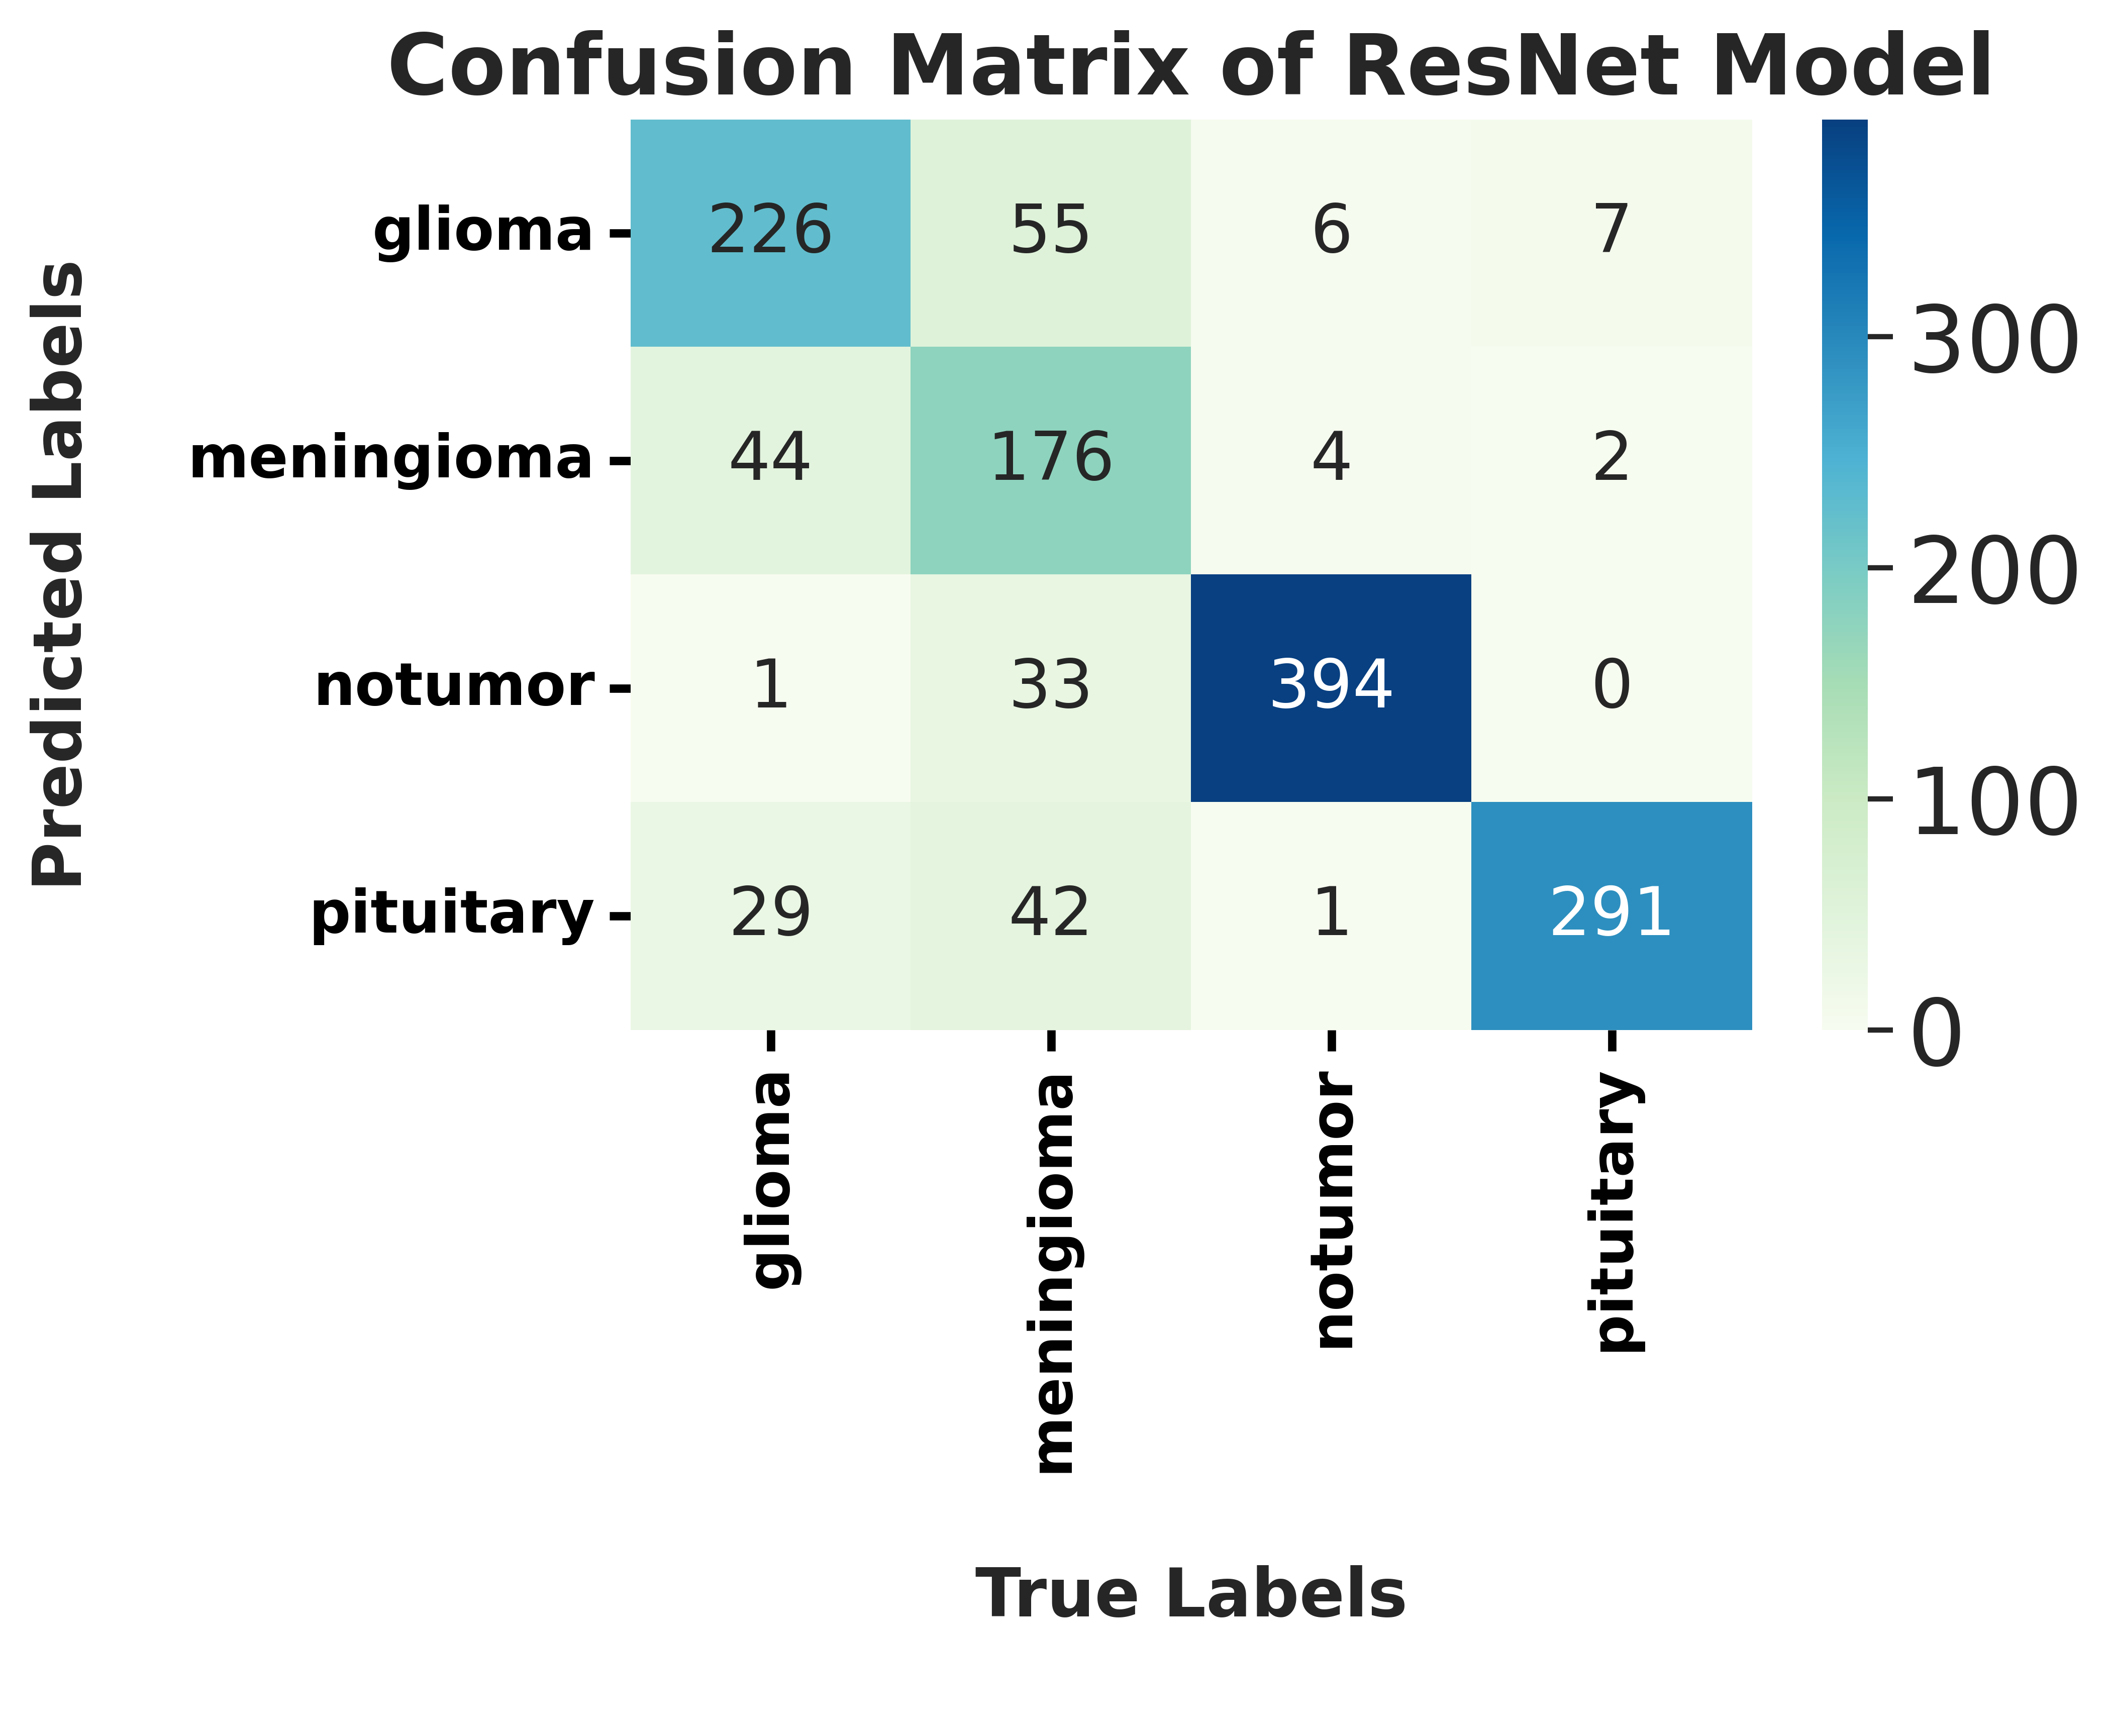

In [ ]:
predict_labels_Test = pred_test
predict_labels_Test1 = predict_labels_Test
predict_labels=np.argmax(predict_labels_Test, axis=1)
# print(predict_labels)

predict_labels_TestV2_ctg = np_utils.to_categorical(predict_labels, num_classes)
labels_Test_ctg = np_utils.to_categorical(test_generator.classes, num_classes)
predict_labels_Ar = np.asarray(predict_labels)
print("\npredict_labels_Test")
print(f'Numbre of {classes[0]} : {(predict_labels_Ar == 0).sum()}')
print(f'Numbre of {classes[1]} : {(predict_labels_Ar == 1).sum()}')
print(f'Numbre of {classes[2]} : {(predict_labels_Ar == 2).sum()}')
print(f'Numbre of {classes[3]} : {(predict_labels_Ar == 3).sum()}')

print("\n"+classification_report(predict_labels_TestV2_ctg, labels_Test_ctg))

cm = confusion_matrix(predict_labels, test_generator.classes) 
#cm1=np.array([[126, 1, 3], [0,193,9],[0,7,190]])

plt.figure()
ax= plt.subplot()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.tick_params(direction='out', length=5, width=2, colors='black',
               grid_color='black', grid_alpha=0.5)
sns.set(font_scale=2)
sns.heatmap(cm, annot= True, fmt='', cmap='GnBu', cbar=True, annot_kws={"size": 16})
labels=classes
plt.rcParams.update(andy_theme)
ax.set_xlabel("\nTrue Labels\n" ,fontweight="bold")
ax.set_ylabel("Predicted Labels\n" ,fontweight="bold")
ax.set_title('Confusion Matrix of ResNet Model',fontweight="bold"); 
ax.xaxis.set_ticklabels(labels,fontweight="bold", rotation = 90,); 
ax.yaxis.set_ticklabels(labels,fontweight="bold", rotation = 0,);

plt.show()


In [ ]:
test_classes=to_categorical(test_generator.classes)

# **ROC AUC Curve**

In [ ]:
AUC=roc_auc_score(test_classes,pred_test)
AUC  

0.96805146711927

ROC AUC score: 0.8806975806139333


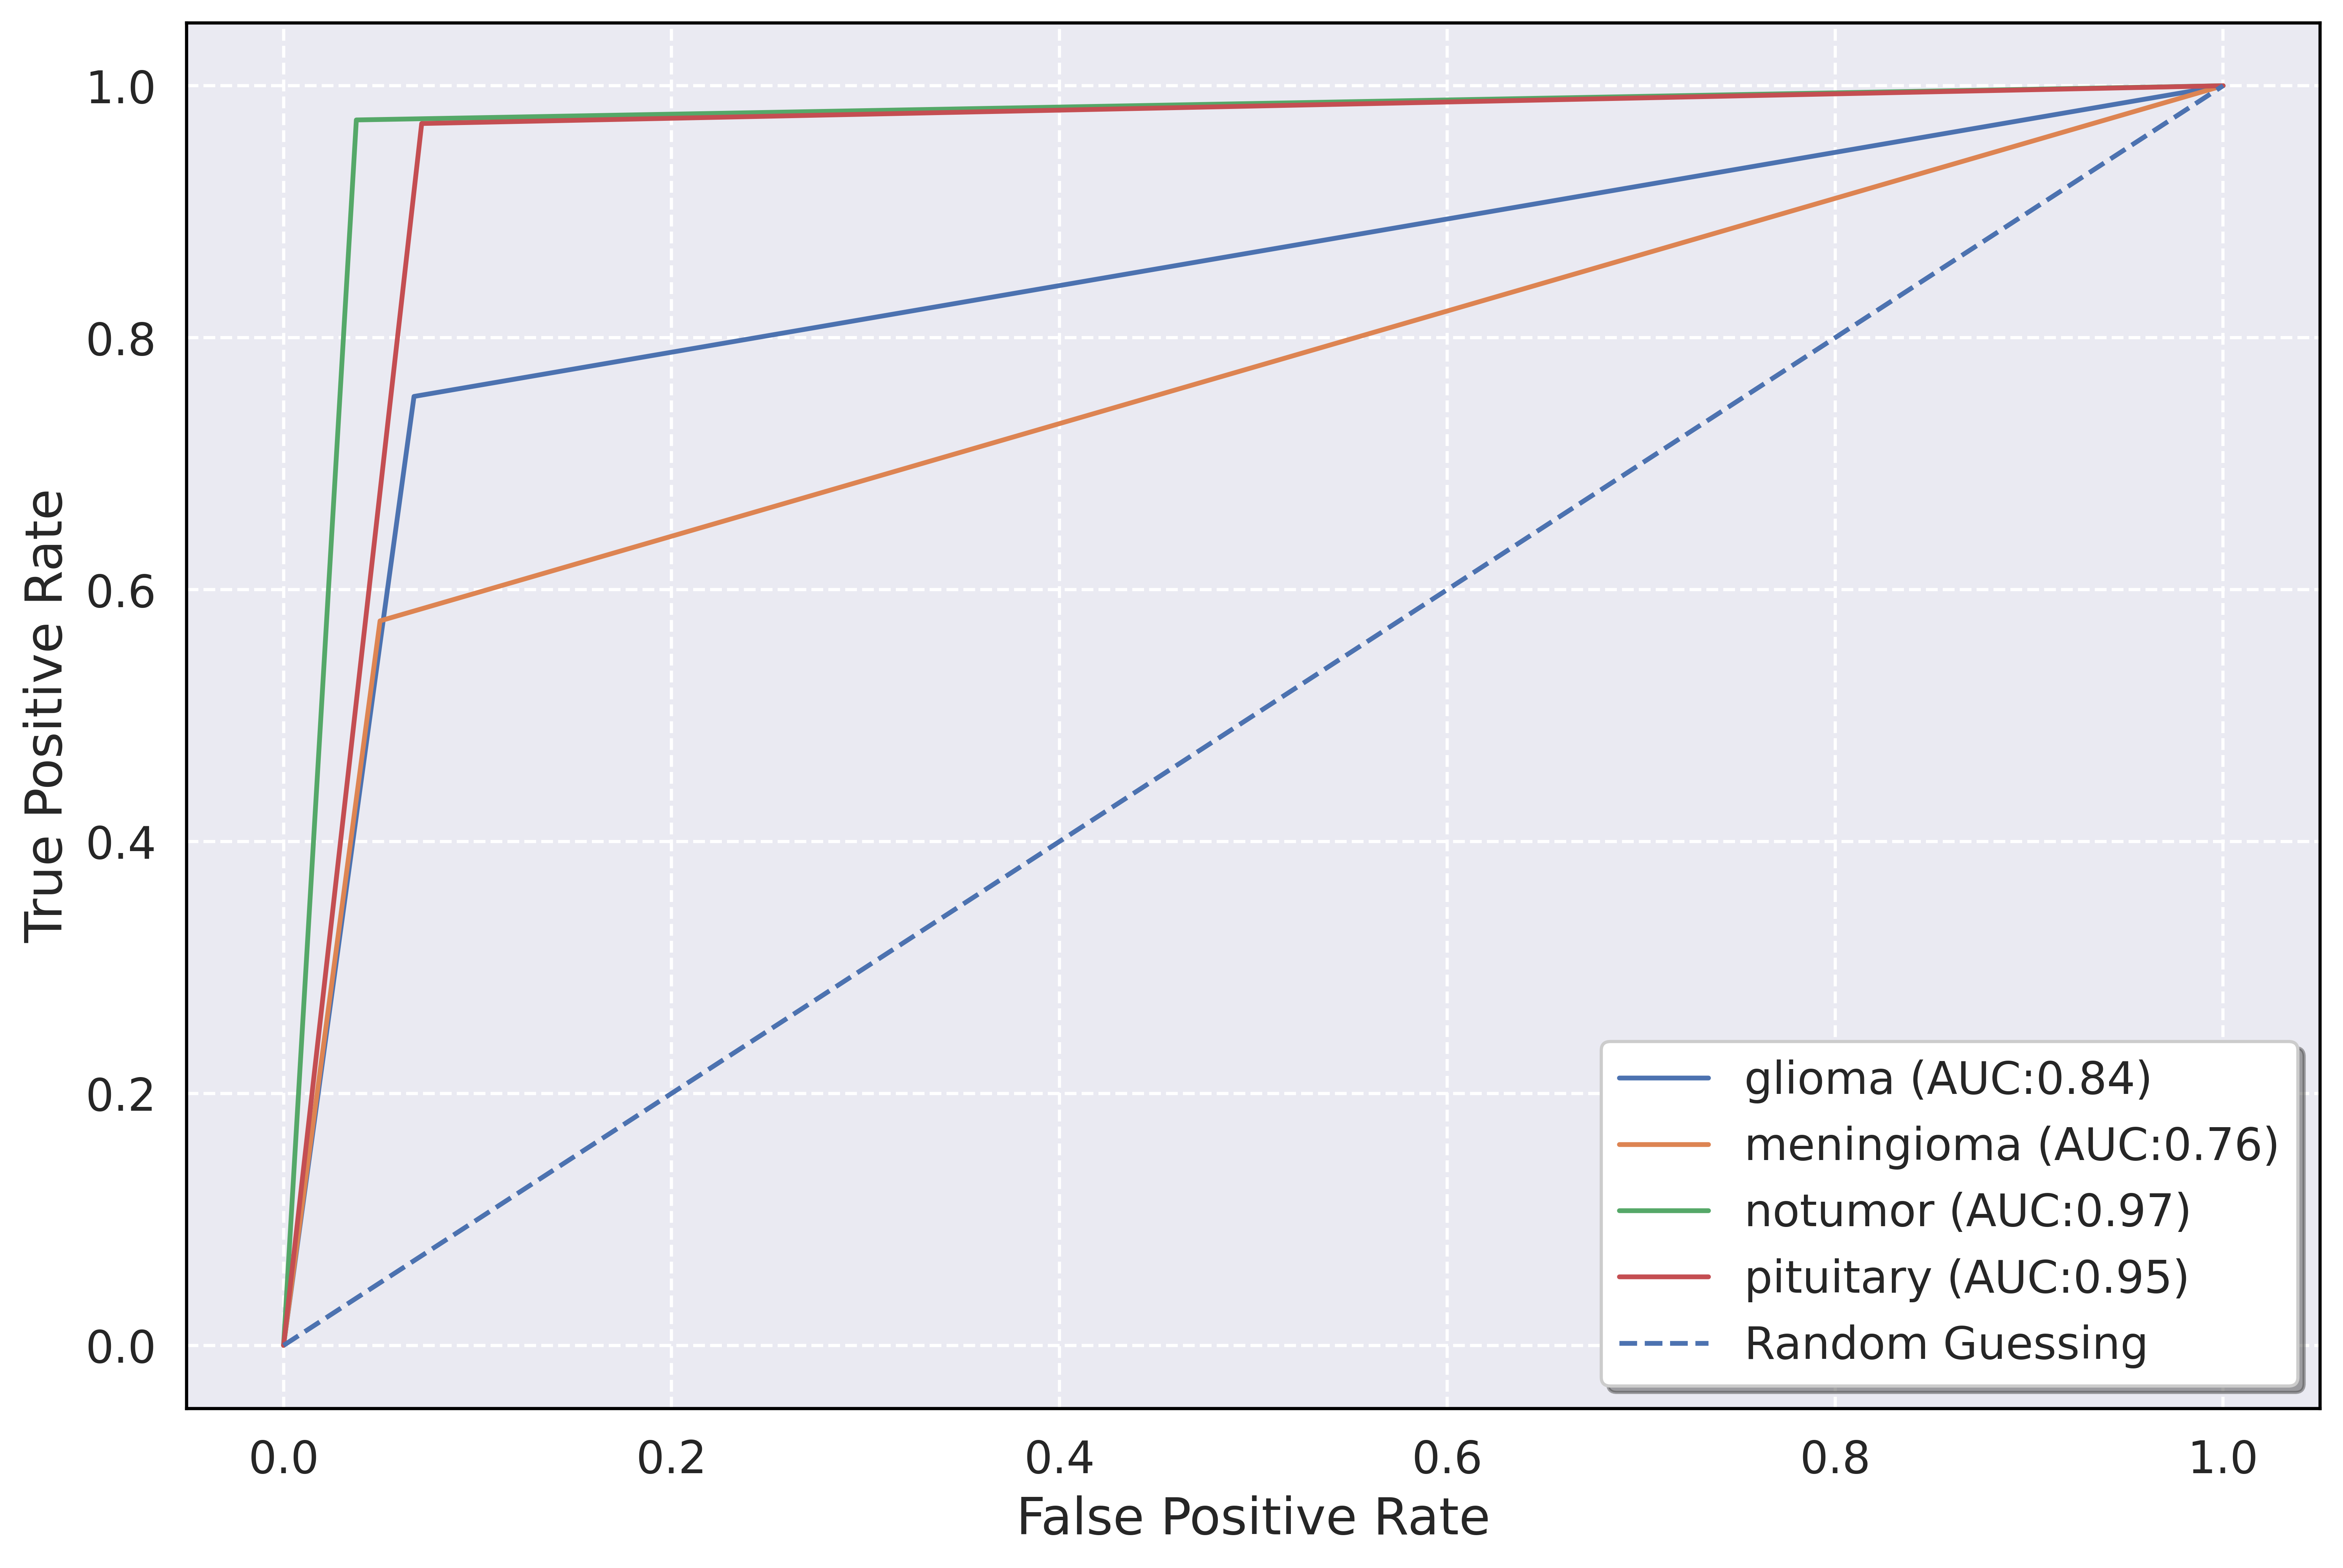

In [ ]:
target= list(test_generator.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-',linestyle='--', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_generator.classes,predict_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


## **Model Testing**

In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(img_rows, img_cols),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True
  )

Found 1311 images belonging to 4 classes.


In [ ]:
images, labels = next(test_generator)
plt.figure(figsize=(20, 20))
for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # plt.grid()
        predictions = model_nw.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        v=np.where(labels[i]==np.max(labels[i]))[0][0]
        if(list(test_generator.class_indices.keys())[v]==list(test_generator.class_indices.keys())[np.argmax(score)]):
            plt.title("Actual: "+ list(test_generator.class_indices.keys())[v],fontsize=20)
            plt.xlabel("Predicted: "+ list(test_generator.class_indices.keys())[np.argmax(score)],fontsize=20,fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+ list(test_generator.class_indices.keys())[v],fontsize=20)
            plt.xlabel("Predicted: "+ list(test_generator.class_indices.keys())[np.argmax(score)],fontsize=20, fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])  
            